# Models Creation

In [24]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [25]:
print(sys.version)

3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:51:40) 
[GCC 13.3.0]


In [26]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-nightly, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 


In [27]:
import tensorflow as tf

In [28]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar el uso de 40 GB en la GPU A100 sin set_memory_growth
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )
    except RuntimeError as e:
        print(e)

In [29]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [30]:
data = pd.read_csv("../data/ml/test.csv")

In [31]:
data

,Video,Evento,PCB,Start_Frame,End_Frame,duracion,Path,is_crime
0,Fighting051_x264.mp4,Fighting,989,1294,3355,2366,../data/test/Fighting051_x264.mp4,1
1,Normal_Videos086_x264.mp4,Normal,0,0,3391,3391,../data/test/Normal_Videos086_x264.mp4,0
2,Normal_Videos405_x264.mp4,Normal,0,0,1065,1065,../data/test/Normal_Videos405_x264.mp4,0
3,Normal_Videos134_x264.mp4,Normal,0,0,4476,4476,../data/test/Normal_Videos134_x264.mp4,0
4,Assault007_x264.mp4,Assault,330,668,1099,769,../data/test/Assault007_x264.mp4,1
...,...,...,...,...,...,...,...,...
60,Normal_Videos456_x264.mp4,Normal,0,0,3943,3943,../data/test/Normal_Videos456_x264.mp4,0
61,Assault013_x264.mp4,Assault,465,615,1022,557,../data/test/Assault013_x264.mp4,1
62,Assault047_x264.mp4,Assault,0,112,1790,1790,../data/test/Assault047_x264.mp4,1
63,Normal_Videos101_x264.mp4,Normal,0,0,1538,1538,../data/test/Normal_Videos101_x264.mp4,0


In [32]:
# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

## Data Loader

In [33]:
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)  # Establecer la semilla

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        step = max(1, (end_frame - start_frame) // self.num_frames)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, self.frame_size)  # Redimensionar
            frame = frame / 255.0  # Normalizar a [0,1]
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)
            
            if training:
                frame = tf.image.random_flip_left_right(frame)
                frame = tf.image.random_brightness(frame, max_delta=0.2)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
                frame = tf.image.random_hue(frame, max_delta=0.05)
                
            frames.append(frame.numpy())
            
            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)

    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                yield video_tensor, labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            )

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## I3D Model

In [34]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Logits"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

In [35]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

2025-04-01 16:07:35.140803: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 16:07:35.557814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-01 16:07:35.558851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-01 16:07:35.562558: I tensorflow/core/common_runtime/gpu/gpu_device.cc

### One Cycle Policy

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import AUC

In [41]:
epochs = 10  # Número de épocas
max_learning_rate = 0.1  # Ejemplo
initial_learning_rate = 1e-5  # Ejemplo
num_classes = 2

In [42]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    max_lr = 1e-3
    min_lr = 1e-6
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

### Modelo

In [43]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [45]:
checkpoint_dir = "checkpoints/i3d_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Callback para guardar TODAS las épocas
full_history_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
    save_freq='epoch',
    save_weights_only=True
)

# Callback para guardar solo el MEJOR modelo
best_model_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_1.load_weights(os.path.join(checkpoint_dir, "best_model"))
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callback para detener el entrenamiento si no hay mejora
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Callback para guardar historial después de cada época
class HistorySaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            history_full['loss'].append(logs.get('loss', None))
            history_full['val_loss'].append(logs.get('val_loss', None))
            np.save(history_file, history_full)  # Guardar historial actualizado

history_saver_callback = HistorySaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_1.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            checkpoint_callback, 
            lr_scheduler, 
            epoch_saver_callback, 
            full_history_callback, 
            best_model_callback,
            history_saver_callback  # Nuevo callback para guardar historial
        ],
        verbose=1
    )

Resuming training from epoch 3
Epoch 4/10


2025-04-01 16:09:56.678492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-04-01 16:10:02.321193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 490ms/step - loss: 1.1228 - accuracy: 0.5769 - val_loss: 0.8247 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets
Epoch 5/10


2025-04-01 16:10:34.953546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:10:41.396267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 493ms/step - loss: 0.9383 - accuracy: 0.4231 - val_loss: 0.9347 - val_accuracy: 0.1667
Epoch 6/10


2025-04-01 16:10:56.298832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:11:02.716186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 490ms/step - loss: 0.7821 - accuracy: 0.4808 - val_loss: 0.9296 - val_accuracy: 0.1667
Epoch 7/10


2025-04-01 16:11:17.645335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:11:24.150648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 497ms/step - loss: 0.8318 - accuracy: 0.5192 - val_loss: 0.9212 - val_accuracy: 0.1667


In [46]:
history_full

{'loss': [0.7296431660652161,
  1.0898278951644897,
  1.2680948972702026,
  1.1227513551712036,
  0.9382906556129456,
  0.782118558883667,
  0.8317811489105225],
 'val_loss': [0.7145546078681946,
  0.8213091492652893,
  1.6127510070800781,
  0.8246566653251648,
  0.9347290396690369,
  0.9296196103096008,
  0.9212115406990051]}

### Evolución del Learning rate

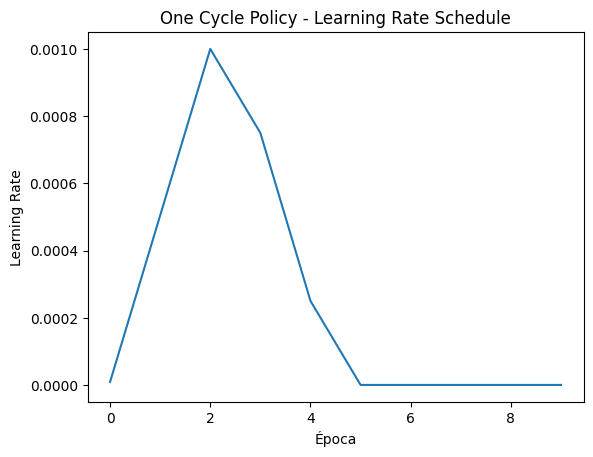

In [47]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [48]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-01 16:12:22.446429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52


      1/Unknown - 17s 17s/step - loss: 0.8349 - accuracy: 0.6250

2025-04-01 16:12:28.095770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 17s 86ms/step - loss: 0.9755 - accuracy: 0.5000


In [49]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.8247 - accuracy: 0.3333


In [50]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 1.1912 - accuracy: 0.4286


In [51]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.9755248427391052, Accuracy: 0.5
Val - Loss: 0.8246566653251648, Accuracy: 0.3333333432674408
Test - Loss: 1.1912086009979248, Accuracy: 0.4285714328289032


### Gráfica Epochs vs Loss

In [52]:
history_full

{'loss': [0.7296431660652161,
  1.0898278951644897,
  1.2680948972702026,
  1.1227513551712036,
  0.9382906556129456,
  0.782118558883667,
  0.8317811489105225],
 'val_loss': [0.7145546078681946,
  0.8213091492652893,
  1.6127510070800781,
  0.8246566653251648,
  0.9347290396690369,
  0.9296196103096008,
  0.9212115406990051]}

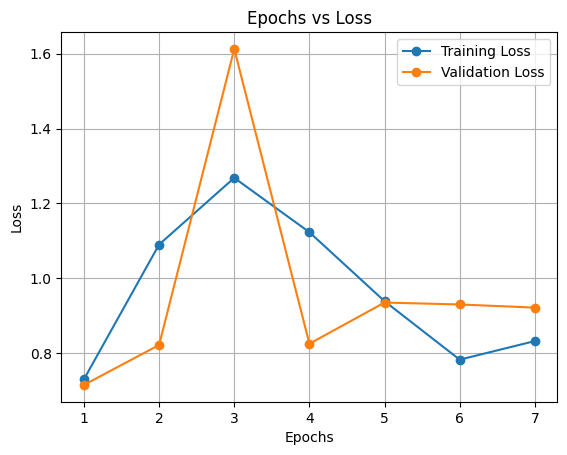

In [53]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 7, Usando perplexity=6


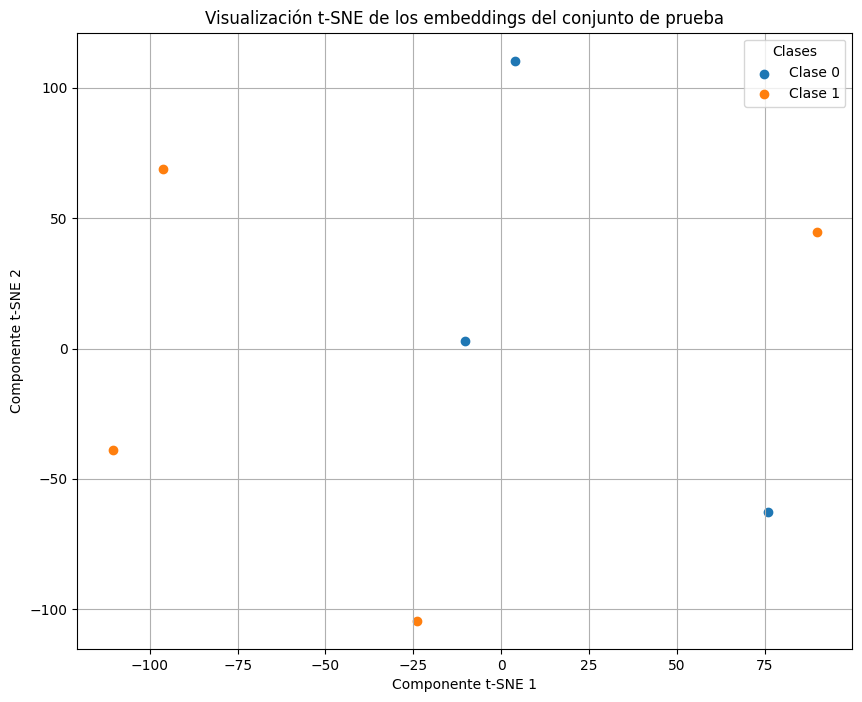

In [54]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## I3D + ConvLSTM2D

In [55]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar información temporal
        self.conv_lstm = ConvLSTM2D(
            filters=64, 
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,  # Mantener la dimensión temporal
            dropout=0.2,
            recurrent_dropout=0.2
        )
        
        # Batch Normalization después de ConvLSTM
        self.batch_norm = BatchNormalization()
        
        # Global Average Pooling para reducir dimensionalidad
        self.global_avg_pool = GlobalAveragePooling2D()  # Cambio a 2D
        
        # Dropout para regularización
        self.dropout = Dropout(0.3)
        
        # Capa completamente conectada final
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Entrada esperada: (batch_size, num_frames, height, width, channels)"""
        
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, 1024)
        
        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, num_frames, 7, 7, 64)
        
        # Tomar solo el último frame de la salida de LSTM para clasificación
        lstm_out = lstm_out[:, -1, :, :, :]  # (batch_size, 7, 7, 64)

        # Batch Normalization
        x = self.batch_norm(lstm_out, training=training)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Dropout para regularización
        x = self.dropout(x, training=training)
        
        # Capa de salida
        logits = self.fc(x)
        
        return logits

In [56]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Modelo

In [57]:
epochs = 10  # Número de épocas
max_learning_rate = 0.1  # Ejemplo
initial_learning_rate = 1e-5  # Ejemplo
num_classes = 2

In [58]:
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [59]:
checkpoint_dir = "checkpoints/i3dLstm_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Callback para guardar TODAS las épocas
full_history_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
    save_freq='epoch',
    save_weights_only=True
)

# Callback para guardar solo el MEJOR modelo
best_model_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_2.load_weights(os.path.join(checkpoint_dir, "best_model"))
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callback para detener el entrenamiento si no hay mejora
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Callback para guardar historial después de cada época
class HistorySaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            history_full['loss'].append(logs.get('loss', None))
            history_full['val_loss'].append(logs.get('val_loss', None))
            np.save(history_file, history_full)  # Guardar historial actualizado

history_saver_callback = HistorySaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_2.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            checkpoint_callback, 
            lr_scheduler, 
            epoch_saver_callback, 
            full_history_callback, 
            best_model_callback,
            history_saver_callback  # Nuevo callback para guardar historial
        ],
        verbose=1
    )

Starting training from scratch.
Epoch 1/10


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2025-04-01 16:14:00.269183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:14:06.746015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


      1/Unknown - 33s 33s/step - loss: 0.7434 - accuracy: 0.3750

2025-04-01 16:14:06.959485: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 40s 1s/step - loss: 0.7337 - accuracy: 0.4808 - val_loss: 0.7246 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: checkpoints/i3dLstm_model/best_model/assets
Epoch 2/10


2025-04-01 16:14:46.426988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-04-01 16:14:52.058710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 514ms/step - loss: 1.1059 - accuracy: 0.5962 - val_loss: 0.7779 - val_accuracy: 0.5000
Epoch 3/10


2025-04-01 16:15:07.681545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:15:14.083678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 502ms/step - loss: 0.7167 - accuracy: 0.7308 - val_loss: 0.8049 - val_accuracy: 0.5000
Epoch 4/10


2025-04-01 16:15:29.495526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:15:35.926497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 501ms/step - loss: 0.8137 - accuracy: 0.5769 - val_loss: 0.6620 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: checkpoints/i3dLstm_model/best_model/assets
Epoch 5/10


2025-04-01 16:16:12.631380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:16:19.039195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 506ms/step - loss: 0.6857 - accuracy: 0.6731 - val_loss: 0.6951 - val_accuracy: 0.3333
Epoch 6/10


2025-04-01 16:16:34.591356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:16:41.063300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 501ms/step - loss: 0.5529 - accuracy: 0.7115 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 7/10


2025-04-01 16:16:56.431166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52
2025-04-01 16:17:02.873498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 20s 503ms/step - loss: 0.6286 - accuracy: 0.6538 - val_loss: 0.6912 - val_accuracy: 0.5000


In [60]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-01 16:17:57.189104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 52


      1/Unknown - 17s 17s/step - loss: 0.6690 - accuracy: 0.6250

2025-04-01 16:18:03.576667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 17s 83ms/step - loss: 0.7001 - accuracy: 0.5769


In [61]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.6620 - accuracy: 0.3333


In [62]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.7959 - accuracy: 0.4286


In [63]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.7001119256019592, Accuracy: 0.5769230723381042
Val - Loss: 0.6620156764984131, Accuracy: 0.3333333432674408
Test - Loss: 0.7959440350532532, Accuracy: 0.4285714328289032


### Evolución del Learning rate

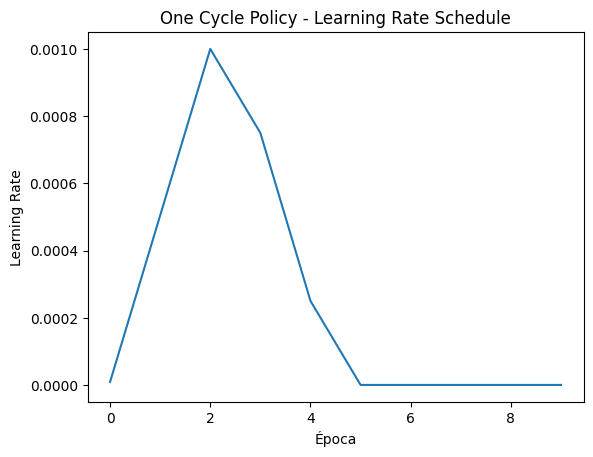

In [64]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráfica Epochs vs Loss

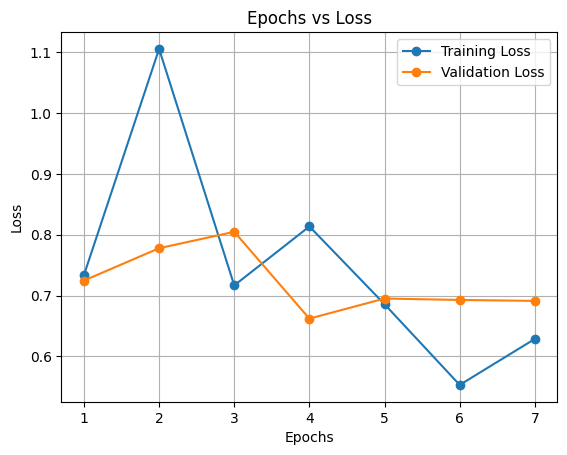

In [65]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 7, Usando perplexity=6


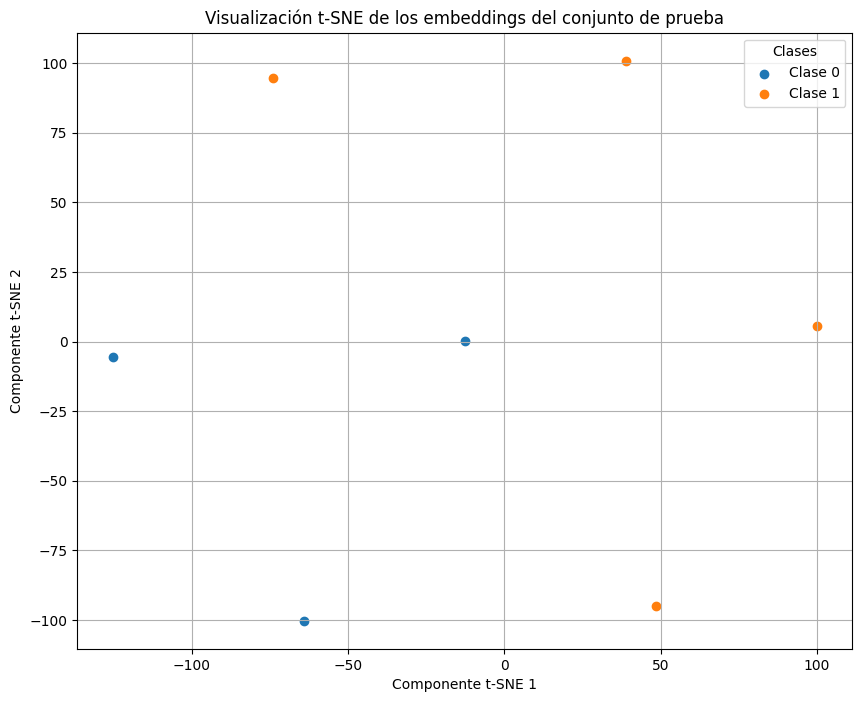

In [66]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [43]:
# Evaluar los modelos en el conjunto de prueba
loss_1, acc_1 = model_1.evaluate(X_test, y_test)
loss_2, acc_2 = model_2.evaluate(X_test, y_test)

print(f"KerasI3D - Loss: {loss_1}, Accuracy: {acc_1}")
print(f"I3D_ConvLSTM - Loss: {loss_2}, Accuracy: {acc_2}")

NameError: name 'X_test' is not defined